In [1]:
import numpy as np
import pandas as pd

import calendar
from datetime import date, timedelta, datetime

import requests

from bs4 import BeautifulSoup

import re

import matplotlib.pyplot as plt

---
# Data Cleaning

**Datasets**
- Daily climate data, spread across numerous .csv files; this dataset will be further split into temperature and rainfall datasets.
- Monthly mean humidity data.
- Weekly infectious diseases data.
- Weekly google search trends data for search term 'dengue'.

**Cleaning**
- Rename columns if necessary.
- Standardise index format for merging purposes later:
    - example for weekly datasets: 2012-W01
    - example for monthly datasets: 2012-M01
    - example for yearly datasets: 2012
- Due to differences in data sources, number of weeks in each year does not correspond across datasets. Therefore, all datasets will be standardised to have 52 weeks per year.
    - For datasets dealing with mean values, the 53rd week, if present, will be averaged with the 52nd week.
    - For datasets dealing with sums, the 53rd week, if present, will be merged with the 52nd week.
    
**Weekly, Monthly & Yearly versions**
- Apart from mean humidity, all other datasets can be compiled to have weekly, monthly and yearly versions.
- Mean humidity data does not come in a weekly version, ie. there are only monthly & annual versions.
---

In [2]:
# Function to 'merge' data from the 53rd week into the 52nd week.

def resolve_conflicts(df=None, year=None, column=None):
    
    try:
        
        df.loc[f'{year}-W52', column] = df.loc[f'{year}-W52', column] + df.loc[f'{year}-W53', column]
            
        if column.startswith('mean'):
            
            df.loc[f'{year}-W52', column] /= 2
        
    except Exception as e:
        
        pass
        
    df.drop(f'{year}-W53', inplace=True, errors='ignore')

---
## `df_climate`
---

In [3]:
# Either read in climate.csv, or create the file if it doesn't yet exist.

try:
    
    df_climate = pd.read_csv('../data/climate.csv')
    df_climate.drop('Unnamed: 0', axis=1, inplace=True)
    
except:
    
    year_and_month = [''.join(i.split('-')[:2]) for i in pd.to_datetime([f'{year}' + f' 0{month}' for year in range(1980,2023) for month in range(1,13)]).astype(str)]
    year_and_month.append('202301')
    year_and_month.append('202302')
    year_and_month = list(set(year_and_month))
    
    urls = [f'http://www.weather.gov.sg/files/dailydata/DAILYDATA_S24_{yyyymm}.csv' for yyyymm in year_and_month]
    
    destination_folder = '../data/'
    
    for url in urls:

        filename = url.split('/')[-1]

        path = destination_folder + filename

        try:

            pd.read_csv(path, encoding='ANSI')

        except:

            response = requests.get(url)

            soup = BeautifulSoup(response.content, 'html.parser')

            content = response.content

            with open(path, 'wb') as f:
                f.write(content)
                
    df_climate = pd.DataFrame()

    for url in urls:

        filename = url.split('/')[-1]

        path = destination_folder + filename

        df = pd.read_csv(path, encoding='ANSI')

        new_cols = [col.lower() for col in df.columns if len(col.split(' ')) < 2] + \
        ['_'.join(col.lower().split(' ')[:-1]) for col in df.columns if '(' in col]

        df.rename(columns={old_col: new_col for old_col, new_col in zip(df.columns, new_cols)}, 
                  inplace=True, 
                  errors='ignore')

        df_climate = pd.concat([df_climate, df.loc[:, lambda x: x.columns.str.contains('station') == False]])

        df_climate = df_climate.sort_values(['year', 'month', 'day'], ascending=True).reset_index().drop('index', axis=1)

        df_climate.to_csv('../data/climate.csv')

In [4]:
# Include 'year_month' column to be used as the index for the temperature & rainfall monthly dataframes.

df_climate['year_month'] = df_climate.apply(lambda x: f'{x.year}-M0{x.month}' if x.month in range(1,10) \
                                            else f'{x.year}-M{x.month}',
                                            axis=1)

In [5]:
# Add in a week column based on isocalendar().
# Will not correspond exactly to how other pre-sorted weekly datasets, but at least it's accurate.

df_climate['week'] = df_climate.apply(lambda x: date(x['year'], x['month'], x['day']).isocalendar()[1], axis=1)

In [6]:
# As isocalendar() considers the first Monday of each year to be the first day of week 1...
# ...the days before that will have to 'belong' to the previous year.
# For example, the first Monday of 2022 is 3/1.
# 1/1 and 2/1 are currently grouped under week 52, ie. the final week of 2021.
# However, they are part of the year 2022.
# This means that these 2 days will be week 52 of year 2022, which is inaccurate.
# The following code is meant to change that, such that they will simply be considered as...
# ...part of the previous year, ie. week 52 of year 2021.

df_climate['year'] = df_climate.apply(lambda x: x.year - 1 if x.month == 1 and x.week > 50 else x.year, axis=1)

In [7]:
# Include 'year_week' column to be used as the index for the temperature & rainfall weekly dataframes.

df_climate['year_week'] = df_climate.apply(lambda x: f'{x.year}-W0{x.week}' if x.week in range(1,10) \
                                           else f'{x.year}-W{x.week}', 
                                           axis=1)

In [8]:
# Filter dataframe to relevant date range.
# Has to be done at this point to avoid errors when trying to convert values to float,
# since, for the earlier years, data is not collected therefore values are nan.

df_climate_2012_2022 = df_climate.loc[lambda x: x.year.between(2012,2022), :]

In [9]:
# Convert str to float so that .mean() can be applied.

df_climate_2012_2022['mean_temperature'] = df_climate_2012_2022.mean_temperature.map(lambda x: float(x))

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_16120/2859946516.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_climate_2012_2022['mean_temperature'] = df_climate_2012_2022.mean_temperature.map(lambda x: float(x))


In [10]:
# Convert str to float so that .sum() can be applied.

df_climate_2012_2022['daily_rainfall_total'] = df_climate_2012_2022.daily_rainfall_total.map(lambda x: float(x))

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_16120/788401491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_climate_2012_2022['daily_rainfall_total'] = df_climate_2012_2022.daily_rainfall_total.map(lambda x: float(x))


In [11]:
# Rename column to be more accurate.

df_climate_2012_2022 = df_climate_2012_2022.rename(columns={'daily_rainfall_total': 'total_rainfall'})

### `df_mean_temp_weekly` & `df_total_rainfall_weekly`

In [12]:
# Create a new dataframe by filtering & grouping data from df_climate_2012_2022 to obtain weekly mean temperature data.

df_mean_temp_weekly = df_climate_2012_2022.groupby('year_week')[['mean_temperature']].mean()

In [13]:
# Create a new dataframe by filtering & grouping data from df_climate_2012_2022 to obtain total rainfall data by week.

df_total_rainfall_weekly = df_climate_2012_2022.groupby('year_week')[['total_rainfall']].sum()

In [14]:
# Using the resolve_conflicts() function, standardise number of weeks in temperature & rainfall datasets to be 52 per year.

for year in range(2012,2023):
    resolve_conflicts(df=df_mean_temp_weekly, year=year, column='mean_temperature')
    resolve_conflicts(df=df_total_rainfall_weekly, year=year, column='total_rainfall')

### `df_mean_temp_monthly` & `df_total_rainfall_monthly`

In [15]:
# Create a new dataframe by filtering & grouping data from df_climate_2012_2022 to obtain monthly mean temperature data.

df_mean_temp_monthly = df_climate_2012_2022.groupby('year_month')[['mean_temperature']].mean()

In [16]:
# Create a new dataframe by filtering & grouping data from df_climate_2012_2022 to obtain total rainfall data by month.

df_total_rainfall_monthly = df_climate_2012_2022.groupby('year_month')[['total_rainfall']].sum()

### `df_mean_temp_yearly` & `df_total_rainfall_yearly`

In [17]:
# Create a new dataframe by filtering & grouping data from df_climate_2012_2022 to obtain yearly mean temperature data.

df_mean_temp_yearly = df_climate_2012_2022.groupby('year')[['mean_temperature']].mean()

In [18]:
# Create a new dataframe by filtering & grouping data from df_climate_2012_2022 to obtain total rainfall data by year.

df_total_rainfall_yearly = df_climate_2012_2022.groupby('year')[['total_rainfall']].sum()

---
## `df_mean_humidity`
---

In [19]:
# Read in monthly mean humidity data.

df_mean_humidity = pd.read_csv('../data/relative-humidity-monthly-mean.csv')

In [20]:
# Rename column to be consistent across dataframes.

df_mean_humidity.rename(columns={'mean_rh': 'mean_humidity'}, inplace=True)

In [21]:
# Include 'year_month' column to be used as the index for the monthly dataframe.

df_mean_humidity['year_month'] = df_mean_humidity.month.map(lambda x: f'{x[:5]}M{x[-2:]}')

In [22]:
# Include 'year' column to be used as the index for the yearly dataframe.

df_mean_humidity['year'] = df_mean_humidity.month.map(lambda x: int(x[:4]))

### `df_mean_humidity_monthly`

In [23]:
# Create a new dataframe by filtering & grouping data from df_mean_humidity to obtain monthly mean humidity data.

df_mean_humidity_monthly = df_mean_humidity.loc[lambda x: x.year.between(2012,2022), :].set_index('year_month')[['mean_humidity']]

### `df_mean_humidity_yearly`

In [24]:
# Create a new dataframe by filtering & grouping data from df_mean_humidity to obtain annual mean humidity data.

df_mean_humidity_yearly = df_mean_humidity.loc[lambda x: x.year.between(2012,2022), :].groupby('year')[['mean_humidity']].mean()

---
## `df_dengue`
---

In [25]:
# Read in weekly infectious diseases data.

df_dengue = pd.read_csv('../data/weekly-infectious-disease-bulletin-cases.csv')

In [26]:
# Drop irrelevant information & merge relevant information.

df_dengue = df_dengue.loc[df_dengue.disease.map(lambda x: (x=='Dengue Fever') | (x=='Dengue Haemorrhagic Fever'))].\
reset_index().drop('index', axis=1).groupby('epi_week')[['epi_week', 'no._of_cases']].sum()

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_16120/996175159.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dengue = df_dengue.loc[df_dengue.disease.map(lambda x: (x=='Dengue Fever') | (x=='Dengue Haemorrhagic Fever'))].\


In [27]:
# Rename column to be more informative.

df_dengue.rename(columns={'no._of_cases': 'dengue_cases'}, inplace=True, errors='ignore')

In [28]:
# Include 'year' column to be used as the index for the yearly dataframe.

df_dengue['year'] = df_dengue.index.map(lambda x: int(x[:4]))

In [29]:
# Include 'year_week' column for grouping purposes later.

df_dengue['year_week'] = df_dengue.index

### `df_dengue_weekly`

In [30]:
# Create a new dataframe by filtering data from df_dengue to obtain total dengue cases by week.

df_dengue_weekly = df_dengue[['dengue_cases']]

In [31]:
# Using the resolve_conflicts() function, standardise number of weeks in dengue dataset to be 52 per year.

for year in range(2012,2023):
    resolve_conflicts(df=df_dengue_weekly, year=year, column='dengue_cases')

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_16120/3989951185.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(f'{year}-W53', inplace=True, errors='ignore')
/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_16120/3989951185.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(f'{year}-W53', inplace=True, errors='ignore')
/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_16120/3989951185.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

### `df_dengue_monthly`

In [32]:
# Function that returns the month given a year and week.

def get_month_from_week(year, week):
    
    date = datetime.strptime(f'{year}-{week}-1', "%Y-%W-%w")
    
    return date.month

In [33]:
# Apply the get_month_from_week function to df_dengue.

df_dengue['month'] = df_dengue.apply(lambda x: get_month_from_week(x.year, int(x.year_week[-2:])), axis=1)

In [34]:
# Include 'year_month' column to be used as the index for the monthly dataframe.

df_dengue['year_month'] = df_dengue.apply(lambda x: f'{x.year}-M0{x.month}' if x.month in range(1,10) \
                                          else f'{x.year}-M{x.month}',
                                          axis=1)

In [35]:
# Create a new dataframe by filtering & grouping data from df_dengue to obtain total dengue cases by month.

df_dengue_monthly = df_dengue.groupby('year_month')[['dengue_cases']].sum()

### `df_dengue_yearly`

In [36]:
# Create a new dataframe by filtering & grouping data from df_dengue to obtain total dengue cases by year.

df_dengue_yearly = df_dengue.groupby('year')[['dengue_cases']].sum()

---
## `df_trends`
---

### `df_trends_weekly`

In [37]:
# Function to read in and clean each trends dataset.

def create_df_trends(path='../data/interest_trend_2012_to_2016.csv'):
    
    # Read in weekly google search trends.
    df = pd.read_csv(path)
    
    # Drop irrelevant first row.
    df = df.iloc[1:, :]
    
    # Rename column to be more informative.
    df.rename(columns={'Category: All categories': 'searches'}, inplace=True, errors='ignore')
    
    # Convert values to int.
    df['searches'] = df.searches.map(lambda x: int(x))
    
    return df

In [38]:
# Create df_trends_weekly by merging 3 dataframes that will be created using the create_df_trends function.

df_trends_weekly = pd.concat([create_df_trends(path=f'../data/interest_trend_{filename}.csv') \
                              for filename in ['2012_to_2016', '2017_to_2021', '2022']])

In [39]:
# Include 'year' column to be used as the index for the yearly dataframe.

df_trends_weekly['year'] = df_trends_weekly.index.map(lambda x: int(x[:4]))

In [40]:
# Add week number column.

df_trends_weekly['week'] = 1
prev_year = None
prev_week = None

for idx, row in df_trends_weekly.iterrows():
    
    year = row['year']
    
    if prev_year is not None and year != prev_year:
        prev_week = None
        
    if prev_week is not None:
        df_trends_weekly.at[idx, 'week'] = prev_week + 1
        
    prev_year = year
    prev_week = row['week']

In [41]:
# Set index to follow the standardised format.

df_trends_weekly.index = df_trends_weekly.apply(lambda x: f'{x.year}-W0{x.week}' if x.week in range(1,10) \
                                                       else f'{x.year}-W{x.week}', 
                                                       axis=1)

In [42]:
# Using the resolve_conflicts() function, standardise number of weeks in trends dataset to be 52 per year.

for year in range(2012,2023):
    resolve_conflicts(df=df_trends_weekly, year=year, column='searches')

### `df_trends_monthly`

In [43]:
# Create df_trends_weekly by merging 3 dataframes that will be created using the create_df_trends function.

df_trends_monthly = create_df_trends(path='../data/interest_trend_2012_to_2022.csv')

In [44]:
# Include 'year' column.

df_trends_monthly['year'] = df_trends_monthly.index.map(lambda x: int(x[:4]))

In [45]:
# Include 'month' column.

df_trends_monthly['month'] = df_trends_monthly.index.map(lambda x: int(x[-2:]))

In [46]:
# Set index to follow the standardised format.

df_trends_monthly.index = df_trends_monthly.apply(lambda x: f'{x.year}-M0{x.month}' if x.month in range(1,10) \
                                                  else f'{x.year}-M{x.month}',
                                                  axis=1)

### `df_trends_yearly`

In [47]:
# Create a new dataframe by filtering & grouping data from df_trends to obtain total searches by year.

df_trends_yearly = df_trends_monthly.loc[lambda x: x.year.between(2012,2022), :].set_index('year').groupby('year')[['searches']].sum()

---
## Obtain Combined Weekly, Monthly & Yearly Data
---
Note: mean humidity data is not available in weekly format.

In [48]:
# Create combined weekly dataframe.

df_all_weekly = pd.concat([df_mean_temp_weekly, 
                           df_total_rainfall_weekly, 
                           df_dengue_weekly, 
                           df_trends_weekly[['searches']]], 
                          axis=1)

In [49]:
# Create combined monthly dataframe.
# (To include dengue data when available.)

df_all_monthly = pd.concat([df_mean_temp_monthly, 
                            df_total_rainfall_monthly, 
                            df_mean_humidity_monthly, 
                            df_dengue_monthly,
                            df_trends_monthly[['searches']]],
                           axis=1)

In [50]:
# Due to the coding steps taken above to ensure consistency of weekly data...
# ...there's an 'extra' month (1/2023) included in the monthly data that should be dropped.

df_all_monthly = df_all_monthly.drop('2023-M01')

In [51]:
# Create combined yearly dataframe.

df_all_yearly = pd.concat([df_mean_temp_yearly, 
                           df_total_rainfall_yearly, 
                           df_mean_humidity_yearly, 
                           df_dengue_yearly, 
                           df_trends_yearly], 
                          axis=1)

# Charts

In [52]:
# Function to create an additional Dataframe that reflects cumulative weekly/monthly data from 2012 to 2022.

def create_cumulative_df(df=None, timeframe=None, scale=None):
    
    df[timeframe] = df.index.map(lambda x: int(x[-2:]))
    
    df_cumulative = pd.DataFrame()
    
    df_cumulative['mean_temperature'] = df.groupby(df[timeframe]).mean_temperature.mean()
    
    df_cumulative['total_rainfall'] = df.groupby(df[timeframe]).total_rainfall.sum()
    
    df_cumulative['dengue_cases'] = df.groupby(df[timeframe]).dengue_cases.sum()
    
    df_cumulative['searches'] = df.groupby(df[timeframe]).searches.sum()
    
    df_cumulative['dengue_cases_scaled'] = df_cumulative.dengue_cases.map(lambda x: x/scale)
    
    if timeframe == 'month':
        
        df_cumulative['mean_humidity'] = df.groupby(df[timeframe]).mean_humidity.mean()
    
    df.drop(timeframe, axis=1, inplace=True, errors='ignore')
    
    return df_cumulative

In [53]:
# Function to plot two line charts together for comparison purposes.

def compare_lines(df=None, cols_list=None, style='o-', title=None):

    ax = df.plot(y=cols_list[0], legend=False, ylabel=cols_list[0], style=style, figsize=(16,6))
    
    ax2 = ax.twinx()
    
    df.plot(y=cols_list[1], ax=ax2, legend=False, ylabel=cols_list[1], color='r', style=style)
    
    ax.figure.legend()
    
    plt.title(title)
    
    plt.show();

In [54]:
# Function to plot three line charts together for comparison purposes.

def compare_3_lines(df=None, cols_list=None, ylim=[20, 30], start=2012, end=2023, style='o-', title=None):

    ax = df.plot(y=cols_list[0], legend=False, ylabel=cols_list[0], style=style, figsize=(16,9))
    
    df.plot(y=cols_list[1], ax=ax, legend=False, ylabel=cols_list[1], color='r', style=style)
        
    ax2 = ax.twinx()

    ax2.set_ylim(ylim[0], ylim[1])

    df.plot(y=cols_list[2], ax=ax2, legend=False, ylabel=cols_list[2], color='g', style=style)
    
    ax.figure.legend()
    
    plt.title(title)
    
    # plt.xlim(start, end)
    
    plt.show();

In [55]:
# Using the create_cumulative_df function, create a Dataframe that reflects cumulative weekly data.

df_all_weekly_cumulative = create_cumulative_df(df=df_all_weekly, timeframe='week', scale=4)

In [56]:
# Using the create_cumulative_df function, create a Dataframe that reflects cumulative monthly data.

df_all_monthly_cumulative = create_cumulative_df(df=df_all_monthly, timeframe='month', scale=10)

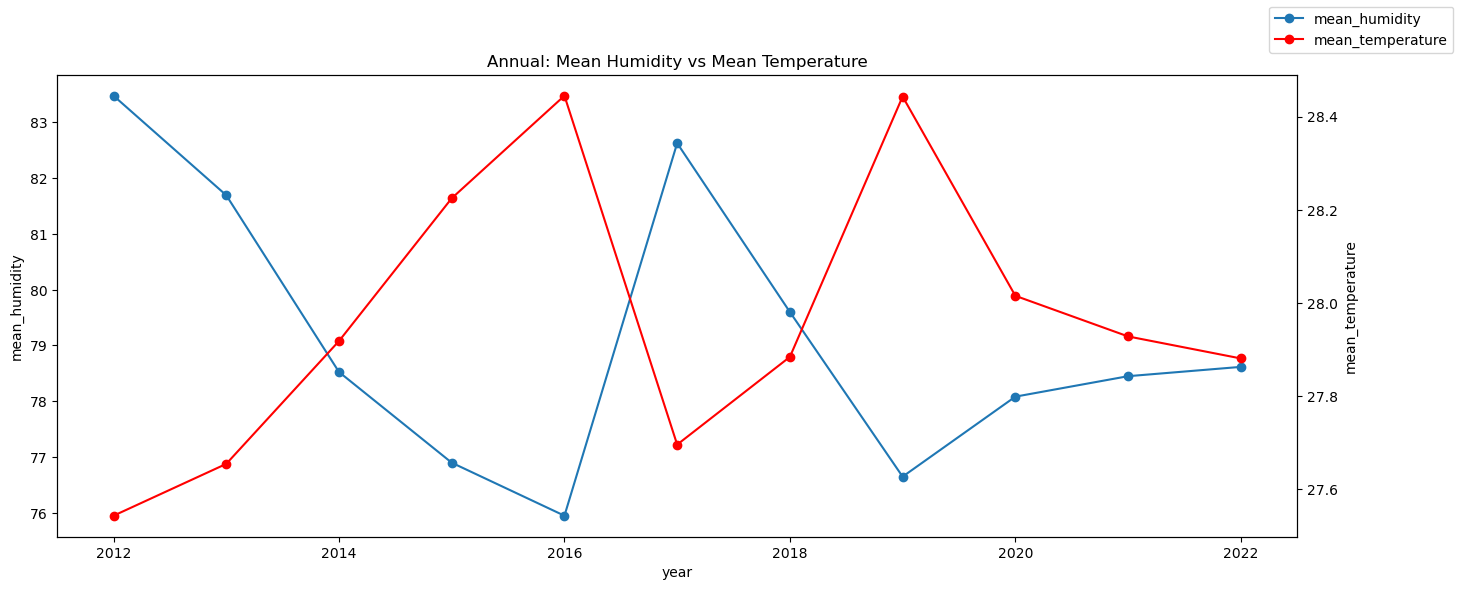

In [57]:
# Humidity and temperature are inversely correlated.

compare_lines(
    df=df_all_yearly, 
    cols_list=['mean_humidity', 'mean_temperature'], 
    style='o-',
    title='Annual: Mean Humidity vs Mean Temperature'
)

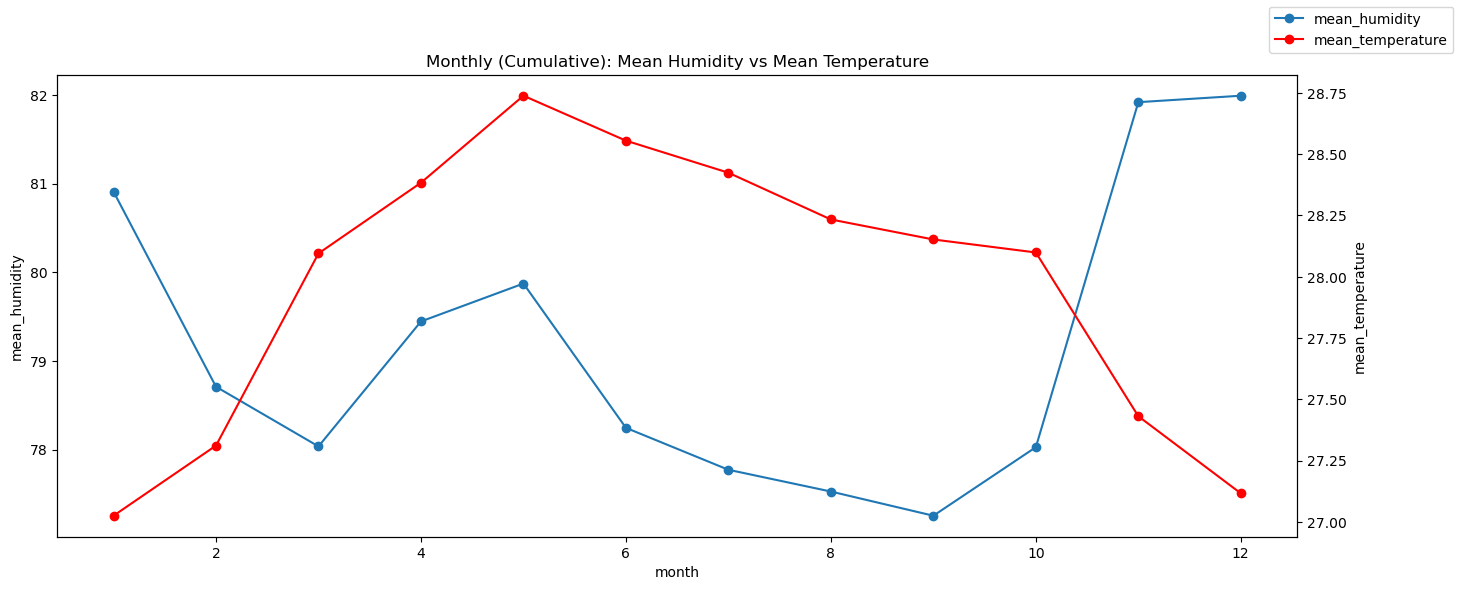

In [58]:
# ...but not always?

compare_lines(
    df=df_all_monthly_cumulative, 
    cols_list=['mean_humidity', 'mean_temperature'], 
    style='o-',
    title='Monthly (Cumulative): Mean Humidity vs Mean Temperature'
)

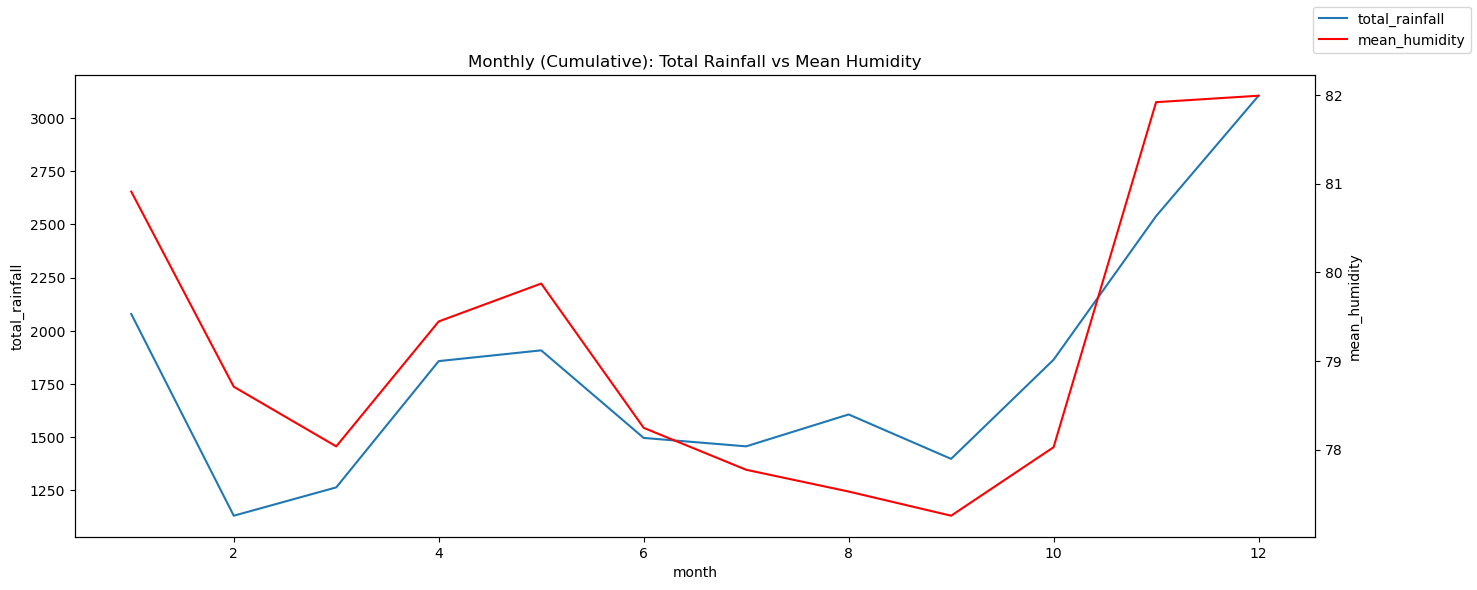

In [59]:
# Rainfall and humidity are positively correlated.

compare_lines(
    df=df_all_monthly_cumulative, 
    cols_list=['total_rainfall', 'mean_humidity'], 
    style='-',
    title='Monthly (Cumulative): Total Rainfall vs Mean Humidity'
)

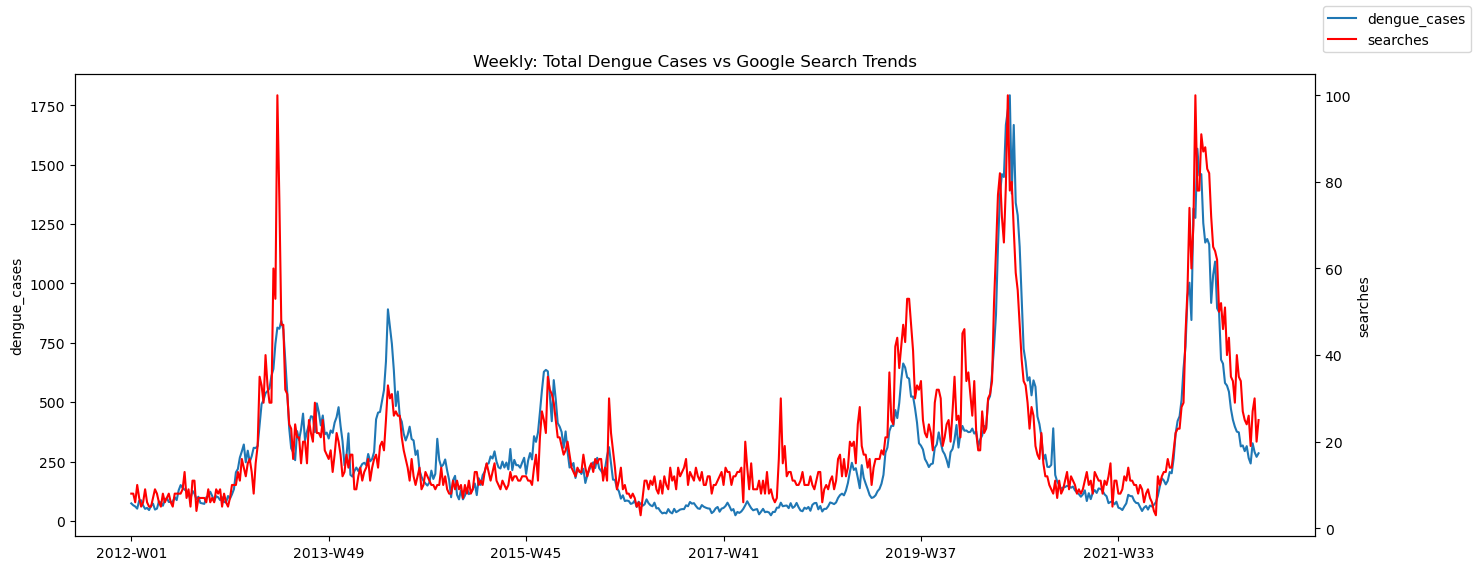

In [60]:
# Google search trends are closely related to and affected by prevailing dengue cases.

compare_lines(
    df=df_all_weekly, 
    cols_list=['dengue_cases', 'searches'], 
    style='-',
    title='Weekly: Total Dengue Cases vs Google Search Trends'
)

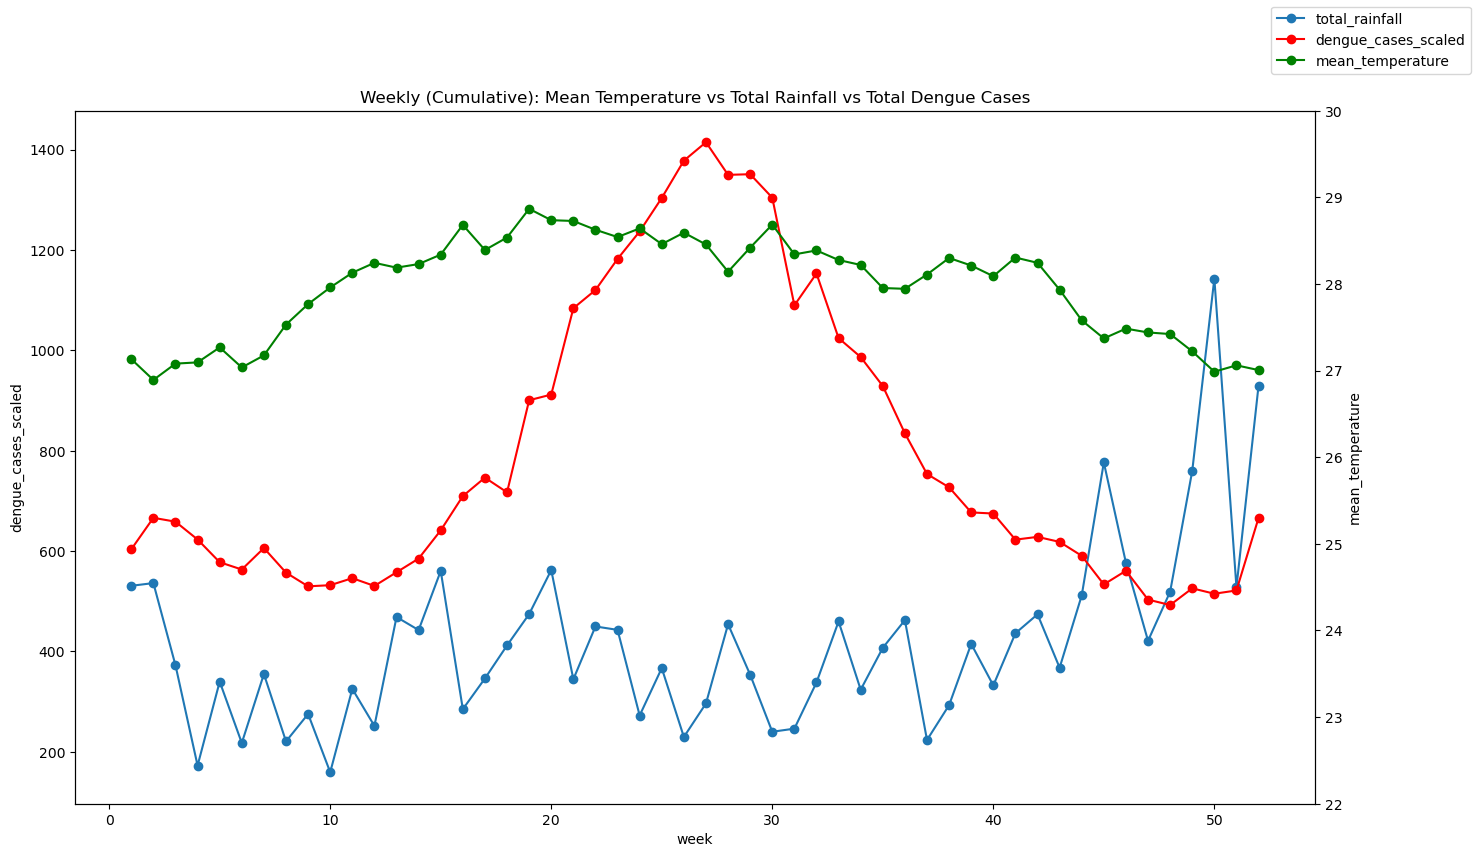

In [61]:
# Examining relationships between temperature, rainfall & dengue cases.

compare_3_lines(
    df=df_all_weekly_cumulative, 
    cols_list=['total_rainfall', 'dengue_cases_scaled', 'mean_temperature'],
    ylim=[22,30],
    style='o-',
    title='Weekly (Cumulative): Mean Temperature vs Total Rainfall vs Total Dengue Cases'
)

In [62]:
df_all_weekly.head(20)

,mean_temperature,total_rainfall,dengue_cases,searches
2012-W01,26.762500,106.8,74,8
2012-W02,26.228571,25.8,66,8
2012-W03,26.914286,28.0,61,6
2012-W04,26.600000,8.6,52,10
2012-W05,26.485714,55.7,85,7
2012-W06,27.500000,1.6,87,5
2012-W07,26.671429,38.2,65,6
2012-W08,27.700000,3.2,51,9
2012-W09,27.142857,26.4,55,6
2012-W10,26.928571,52.6,46,5


In [64]:
df_all_weekly.to_csv('../data/df_all_weekly.csv')